### Use TCGA expression data to train RB1 signature

In [92]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression, SGDClassifier
from matplotlib import pyplot as plt

import helper

%matplotlib inline

### 1. TCGA expression data and RB1 mutation data preprocessing 

In [2]:
mRNA_file = "./data/TCGA/mRNA.tsv"
mutation_file = "./data/TCGA/RB1_maf.tsv"
clinical_file = "./data/TCGA/clinical.tsv"
copynumber_file = "./data/TCGA/RB1_copynumber.tsv"

In [23]:
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
# dropna
mRNA_df.dropna(inplace=True)
# transpose
mRNA_df_transposed = mRNA_df.set_index("gene_id").transpose()
# take log
mRNA_df_transposed_log = mRNA_df_transposed.applymap(lambda x:np.log(x+1))
# save preprocessed mRNA (dropna, transpose, log)
mRNA_df_transposed_log.index.name = "sample_id"
mRNA_df_transposed_log.to_csv("./data/TCGA/mRNA_transpose_log.csv")

In [364]:
# get just prostate tissue
def get_label(barcode, dic):
    patient_id = barcode[:12]
    if patient_id in dic:
        return dic[patient_id]
    else:
        return None

mRNA_df = pd.read_csv("./data/TCGA/mRNA_transpose_log.csv")
clinical_df = pd.read_csv(clinical_file, delimiter="\t", 
                          encoding="ISO-8859-1", low_memory=False)
tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
label_df = pd.DataFrame(index=mRNA_df.sample_id)
label_df["tissue"] = list(mRNA_df.sample_id.apply(lambda x: get_label(x, tissue_dict)))
prostate_samples = list(label_df[label_df.tissue == "PRAD"].index)
prostate_mRNA_df = mRNA_df[mRNA_df.sample_id.isin(prostate_samples)]
prostate_mRNA_df.to_csv("./data/TCGA/mRNA_transpose_log_prostate.csv", index=None)

In [246]:
# get RB1 mutation status from MAF file
def is_RB1_mutated(variant_classification):
    if variant_classification in ["Silent", "3'UTR", "Intron"]:
        return 0
    else:
        return 1
    
def add_to_label(barcode):
    if barcode[:15] not in RB1_dict.keys():
        return 0
    else:
        return RB1_dict[barcode[:15]]
    
    
rb_df = pd.read_csv(mutation_file, delimiter="\t")
rb_df["RB1_mutated"] = rb_df.Variant_Classification.apply(is_RB1_mutated)
RB1_dict = dict(zip([i[:15] for i in rb_df.Tumor_Sample_Barcode], 
                    rb_df.RB1_mutated))

assert(list(label_df.index) == list(mRNA_df.sample_id))
label_df["RB_mutated"] = list(map(add_to_label, list(label_df.index)))
label_df.RB_mutated.value_counts()

0    10684
1      385
Name: RB_mutated, dtype: int64

In [275]:
# get RB1 mutation from copy number file
def add_RB_cnv_info(barcode):
    sample_id = barcode[:15]
    if sample_id not in RB1_cnv_dict.keys():
        return 0
    else:
        copynumber = RB1_cnv_dict[sample_id]
        if copynumber == -2:
            return 1
        else: return 0

df_cnv = pd.read_csv(copynumber_file, delimiter="\t")
sample_cols = [i for i in df_cnv.columns if "TCGA" in i]
df_cnv = df_cnv[sample_cols]
RB1_cnv_dict = dict(zip([i[:15] for i in df_cnv.columns], df_cnv.iloc[0]))
label_df["RB_mutated1"] = list(map(add_RB_cnv_info, list(label_df.index)))
label_df.RB_mutated1.value_counts()

0    10769
1      300
Name: RB_mutated1, dtype: int64

In [283]:
label_df["rb_final"] = 0
label_df.loc[(label_df.RB_mutated==1)|(label_df.RB_mutated1==1), "rb_final"] = 1
label_df.rb_final.value_counts()

0    10404
1      665
Name: rb_final, dtype: int64

In [284]:
label_df[label_df.tissue=="PRAD"]["rb_final"].value_counts()

0    502
1     48
Name: rb_final, dtype: int64

In [285]:
label_df.to_csv("./data/TCGA/RB_labels.csv")

### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.1 with just prostate sample

In [2]:
classifiers = {"LR": LogisticRegression(penalty="l1", C=0.05, class_weight="balanced"),
               "ElasticNet": SGDClassifier(loss="log", penalty="elasticnet", 
                                           alpha=0.01, n_iter=100, random_state=0)}

In [3]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X_prostate = pd.read_csv("./data/TCGA/mRNA_transpose_log_prostate.csv", index_col="sample_id")
y_prostate = label_df[label_df.tissue=="PRAD"].rb_final
assert(list(X_prostate.index) == list(y_prostate.index))

In [4]:
# stratified cross validation
# high regularization
# balance class weight with label frequency
X = X_prostate.as_matrix()
y = y_prostate.as_matrix()

result_df = helper.stratified_cv(X, y, classifiers["LR"])

1,2,3,4,5,6,7,8,9,10,

In [5]:
result_df

,1,2,3,4,5,6,7,8,9,10
train AUC,0.919095,0.930181,0.938593,0.942478,0.931956,0.951327,0.943584,0.946903,0.941372,0.952434
test AUC,0.621569,0.680392,0.740000,0.830000,0.750000,0.730000,0.760000,0.630000,0.390000,0.690000


In [6]:
result_df.mean(axis=1)

train AUC    0.939792
test AUC     0.682196
dtype: float64

In [10]:
clf = classifiers["LR"]
clf.fit(X, y)
gene_coef = clf.coef_[0]

In [16]:
TCGA_prostate_RB_signature_df = pd.DataFrame(index=X_prostate.columns, columns=None, data=gene_coef)

In [53]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None)
RBsig_prostate[0] = RBsig_prostate[0].apply(lambda x:x.split("|")[0])
RBsig_prostate.to_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None, index=None)

### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.1 with all TCGA samples

In [2]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X = pd.read_csv("./data/TCGA/mRNA_transpose_log.csv", index_col="sample_id")

In [11]:
y = label_df.rb_final
assert(list(X.index) == list(y.index))
classifiers = {"LR": LogisticRegression(penalty="l1", C=0.01, 
                                        class_weight="balanced", 
                                        n_jobs=40)}
result_df = helper.stratified_cv(X.as_matrix(), y.as_matrix(), 
                                 classifiers["LR"], folds=5)

1,2,3,4,5,6,7,8,9,10,

In [12]:
result_df

,1,2,3,4,5,6,7,8,9,10
train AUC,0.918210,0.914508,0.915755,0.915293,0.917876,0.917293,0.917740,0.919429,0.915929,0.919361
test AUC,0.860496,0.851112,0.851592,0.832086,0.805095,0.841419,0.825422,0.805696,0.791754,0.836364


In [13]:
result_df.mean(axis=1)

train AUC    0.917139
test AUC     0.830104
dtype: float64

In [16]:
clf = classifiers["LR"]
clf.fit(X.as_matrix(), y.as_matrix())
gene_coef = clf.coef_[0]

In [19]:
TCGA_RB_signature_df = pd.DataFrame(index=X.columns, columns=None, 
                                    data=gene_coef)
TCGA_RB_signature_df.to_csv("./data/TCGA/RBsig_TCGA.csv", header=None)

In [55]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA.csv", header=None)
RBsig_prostate[0] = RBsig_prostate[0].apply(lambda x:x.split("|")[0])
RBsig_prostate.to_csv("./data/TCGA/RBsig_TCGA.csv", header=None, index=None)

### 3. Apply RB signatures to WCDT data

In [34]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_df = pd.read_csv(WCDT_mRNA, delimiter="\t", index_col="gene_id").T

In [84]:
RBsig_prostate = pd.read_csv("./data/TCGA/RBsig_TCGA_prostate.csv", header=None)
RBsig_all = pd.read_csv("./data/TCGA/RBsig_TCGA.csv", header=None)
assert(list(RBsig_prostate[0])==list(RBsig_all[0]))

In [85]:
common_genes = sorted(list(set(RBsig_prostate[0]).intersection(set(WCDT_df.columns))))

In [86]:
WCDT_RBscore_prostate = np.dot(WCDT_df[common_genes].as_matrix(), 
                               RBsig_prostate.set_index(0).loc[common_genes].as_matrix())
WCDT_RBscore_all = np.dot(WCDT_df[common_genes].as_matrix(), 
                          RBsig_all.set_index(0).loc[common_genes].as_matrix())

In [87]:
RBscores = pd.DataFrame(index=WCDT_df.index)
RBscores["RBsig_prostate"] = WCDT_RBscore_prostate
RBscores["RBsig_all"] = WCDT_RBscore_all

In [88]:
RBscores

,RBsig_prostate,RBsig_all
DTB-001,-12.840690,-4.845923
DTB-181,-5.590631,2.535784
DTB-159,-8.032923,-2.647400
DTB-141Pro,-4.655196,-1.656770
DTB-137Pro,-2.289378,-4.291906
DTB-135,-11.936597,3.191317
DTB-132,-10.274254,-1.638149
DTB-126,-9.439564,-4.500719
DTB-124,-11.528793,-2.838809
DTB-121,-12.713190,0.024607


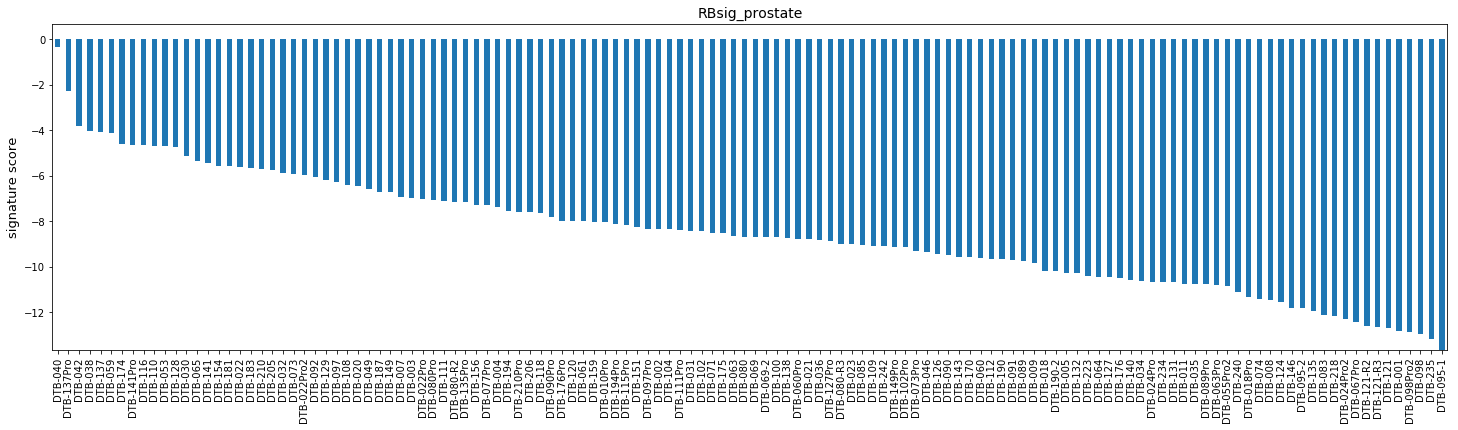

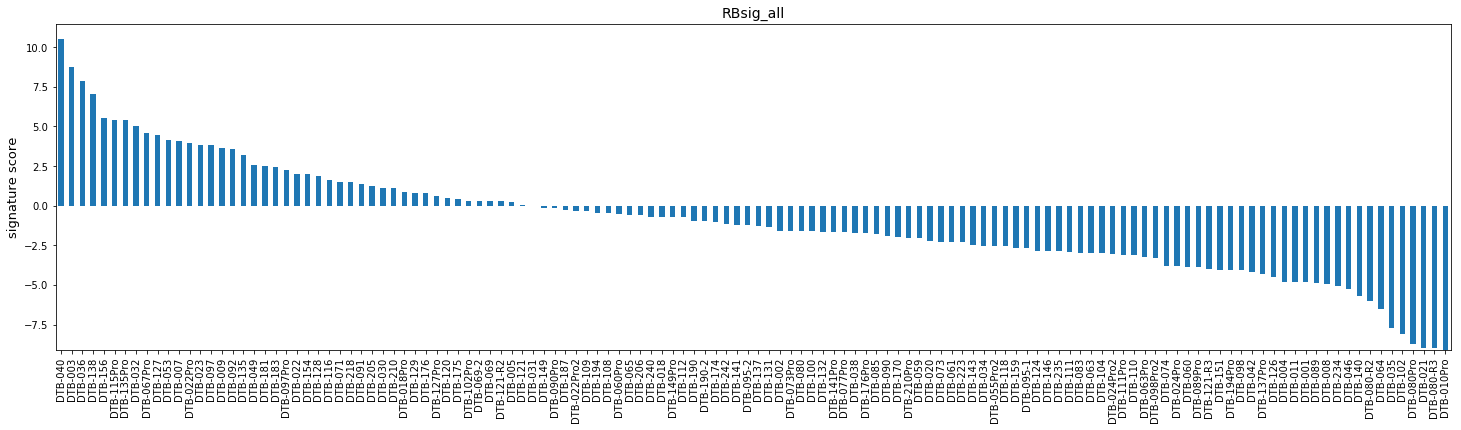

In [97]:
# apply NEPC signatures to known samples
for sig in RBscores.columns:
    RBscores.sort_values(sig, ascending=False, inplace=True)
#     small_cell = list(y[y["NEPC_label"] == 1].index)
#     adeno = list(y[y["NEPC_label"] != 1].index)
#     colors = dict(zip(small_cell + adeno, ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(adeno)))
    fig, ax= plt.subplots()
    fig.set_size_inches(25,6)
    RBscores[sig].plot.bar(ax=ax)
    ax.set_ylabel("signature score", fontsize=13)
#     ax.legend(["Known small cell"], fontsize=13)
    ax.set_title("{0}".format(sig), fontsize=14)
    fig.savefig("./{0}_scores.png".format(sig), dpi=200)